In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from mpl_toolkits.basemap import Basemap  

%matplotlib inline

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 16

# Fun with Google location history

This notebook look at some location data provided by the [Google takeout](https://www.google.com/settings/takeout)
website. It was inspired from this 
[original post by Chris Albon](http://www.chrisalbon.com/map-your-google-location-history/).

In the first part we follow Chris's advise on how to import the `Json` data, then set up a helper function to 
plot the data using `matplotlib.basemap`. The second part we will look at ways to separate the data: initially a simple bisection is used to separate home and away. Then we use a more complex clustering algorithm. 

## Part I:  Getting the data

Having downloaded the `json` data to a file `LocationHistory.json` in the local
directory (or just amend the path below), we start by following Chris Albons post
and generating a first plot of the data. 

In [4]:
 # Create a dataframe from the json file in the filepath
raw = pd.io.json.read_json('LocationHistory.json') 
df = raw['locations'].apply(pd.Series) 

# Create a list from the latitude column, multiplied by -E7
df['latitude'] = df['latitudeE7'] * 1e-7

# Create a list from the longitude column, multiplied by -E7
df['longitude'] = df['longitudeE7'] * 1e-7

This gives us a `pandas` dataframe with columns of the latitude and longitude for each recorded point in my location history. There are several other columns as well, but for the time being lets ignore these. 

Now we define a helper function which will plot all of the relevant data
in a data frame. This will be useful later on when we want to plot only
some subset.

In [5]:
def PaddingFunction(xL, xR, frac=0.1):
    """ Return xL and xR with an added padding factor of frac either side """
    xRange = xR - xL
    xL_new = xL - frac*xRange
    xR_new = xR + frac*xRange
    return xL_new, xR_new

def GeneratePlot(data, fig=None, ignore_first=False, *args, **kwargs):
    """ Helper function to plot points on a map
    
    Parameters
    ----------
    ignore_first : bool, 
        If true the data in the first df in data is ignored and used only to set 
        up the map 
    """
    if type(data) == pd.core.frame.DataFrame:
        # Single df
        df = data
        df_list = [df]
    elif type(data) == list:
        df_list = data
        df = data[0]

    
    if not fig:
        fig = plt.figure()

    # Calculate some parameters which will be resused]
    lat_0 = df.latitude.mean()
    lon_0 = df.longitude.mean()
    llcrnrlon, urcrnrlon = PaddingFunction(df.longitude.min(), df.longitude.max(), frac=0.3)
    llcrnrlat, urcrnrlat = PaddingFunction(df.latitude.min(), df.latitude.max())

    # Create a map, using the Gall–Peters projection, 
    m = Basemap(projection='gall',  
                  resolution = 'l', 
                  area_thresh = 10000.0,
                  lat_0=lat_0, lon_0=lon_0,
                  llcrnrlon=llcrnrlon,
                  urcrnrlon=urcrnrlon,
                  llcrnrlat=llcrnrlat, 
                  urcrnrlat=urcrnrlat,
                  ax=fig.gca()
                  )

    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = '#996633')
    m.drawmapboundary(fill_color='#0099FF')

    if ignore_first:
        df_list = df_list[1:]
        
    for df in df_list:
        # Define our longitude and latitude points
        x, y = m(df['longitude'].values, df['latitude'].values)

        # Plot them using round markers of size 6 
        m.plot(x, y, "o", zorder=100, *args, **kwargs)

    return fig

Okay so finally, lets plot *all* the data

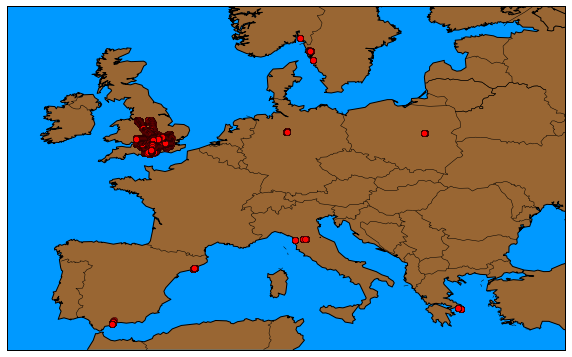

In [6]:
fig = GeneratePlot(df, color="r")

## Part II: Exploring the data

Okay there is clearly a large amount of data in and near to my home in the UK, then several holidays and conferances spread across Europe. The first thing to do will be to separate our data geographically. 

Clustering algorithms are a good way to separate data such as this. However, in this data set there is 
an unreasonably large fraction of the points in one cluster (around the UK). While there may be some 
algorithms which can handle this, a more sensible method is to use our intuition first. We can do this
by bisecting the data based on the distance from a single point. For reasons of simpicity we will use
Greenwhich as this point (the longitude is rather easy to remember here). 

### Distance from Greenwhich

The distance between any points $A$ and $B$ with latitude and longitude $\phi, \lambda$ is given by 
the [Haversine formulae](http://en.wikipedia.org/wiki/Haversine_formula):

\begin{equation}
d = 2r \arcsin\left(\sqrt{\mathrm{haversin}(\phi_{A} - \phi_{B}) + \cos(\phi_A)\cos(\phi_B) 
        \mathrm{haversin}(\lambda_{A} - \lambda_{B})}\right)
\end{equation}

where $r$ is the Earth's radius, and the haversine function is given by 

\begin{equation}
\mathrm{haversine}(\theta) = \sin^{2}\left(\frac{\theta}{2}\right)
\end{equation}

So if we know the [latitude and longitude of Greenwhich](https://www.google.co.uk/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#safe=off&q=latitude+and+longitude+of+greenwich) we can code this into a python function. We will then add this as a new column to our data frame.

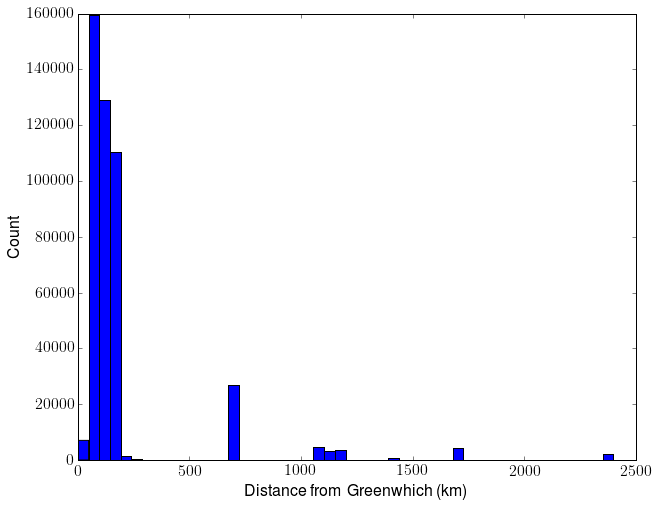

In [7]:
def Haversine(theta):
    return np.sin(theta/2.0)**2

def DistanceFromGreenwhich(lat, lon):
    R = 6.371e6 # m
    latG, lonG = 51.48, 0.00 # Grenwhich lat and long
    latG = np.radians(latG)
    lonG = np.radians(lonG)
    lat = np.radians(lat)
    lon = np.radians(lon)
    arg = Haversine(lat - latG) + np.cos(latG)*np.cos(lat)*Haversine(lon - lonG)
    return 2 * R * np.arcsin(np.sqrt(arg))

df['DistanceFromGreenwhich'] = DistanceFromGreenwhich(df.latitude, df.longitude)

fig, ax = plt.subplots()
out = ax.hist(df.DistanceFromGreenwhich * 1e-3, bins=50)
ax.set_xlabel("Distance from Greenwhich (km)")
ax.set_ylabel("Count")
plt.show()

This shows that $\sim$ 500 km is a good cut-off to describe if a point is from home or away. Lets generate a new dataframe with data from abroad only

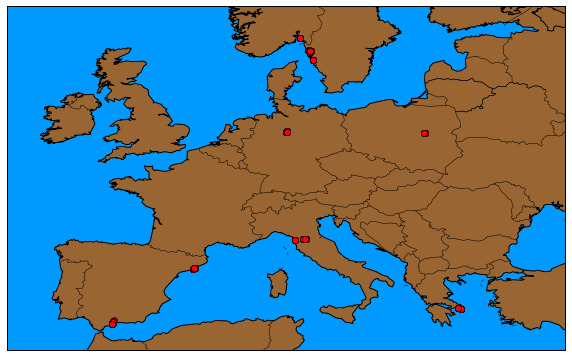

In [13]:
df_away = df[df.DistanceFromGreenwhich > 300e3].copy(deep=True)
fig = GeneratePlot(df_away, color="r")

### Clustering the away points

We now have a good set of sample data to apply a basic sampling algorithm. Since the clusters are
of relatively even size, and we can easily by eye assign 7 clusters, we will use the [K-means clustering
algorithm](http://en.wikipedia.org/wiki/K-means_clustering). Several `python` interfaces exist, for now I
will use the excellent [scikit-learn](http://scikit-learn.org/stable/modules/clustering.html) module.

In [35]:
from scipy.cluster.vq import kmeans,vq

data = np.vstack((df_away.latitude.values, df_away.longitude.values)).T
centroids,_ = kmeans(data, 7, iter=50, thresh=1e-9)
idx,_ = vq(data, centroids)
df_away['cluster_idx'] = idx

This has created a new column in the data frame, the cluster index to which `kmeans` has assigned the point. We can plot all the data frames indicating the cluster by color as follows. Note that the original data frame is passed in as the first element of `df_list`, this is done only to set up the map and is ignored due to the `ignore_first` flag. 

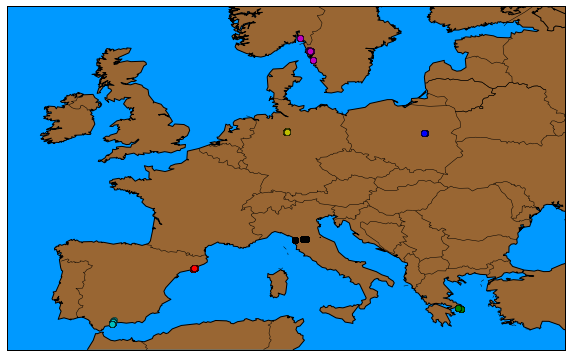

In [36]:
df_list = [df]
for idx in df_away.cluster_idx.unique():
    df_list.append(df_away[df_away.cluster_idx == idx])

fig = GeneratePlot(df_list, ignore_first=True)

We have succesfully clustered the data by region, it should be noted that there is some tweaking required with the  `iter` and `thresh` arguments for the `kmeans` algorithm.